<a href="https://www.kaggle.com/code/atharvaraibagi/credit-risk-evaluation-for-loan-approval?scriptVersionId=211846122" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Importing Libraries

In [9]:
# pip install optbinning
# !pip install shap

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from optbinning import OptimalBinning
import regex as re

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb
from xgboost import XGBClassifier, XGBRFClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')
%matplotlib inline

(CVXPY) Dec 08 09:29:36 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Dec 08 09:29:36 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


### Import Data

In [11]:
def load_data(filepath):
    if file_path[-3:] == 'csv':
        return pd.read_csv(file_path)
    elif file_path[-3:] == 'txt':
        return pd.read_csv(file_path, delimiter='\t')
    elif file_path[-4:] == 'json':
        return pd.read_json(file_path)
    elif file_path[-4:] == 'xlsx':
        return pd.read_excel(file_path)
    else:
        print("An error occured, use ['csv', 'xlsx', 'txt', 'json'] files only")

In [13]:
file_path = "/kaggle/input/loan-approval-classification-data/loan_data.csv"
data = load_data(file_path)
data.drop(columns=['previous_loan_defaults_on_file'], inplace=True)

### Basic Info

In [4]:
def view_data(df):
    print("First 5 rows of the data:")
    display(df.head())
    
    print("Shape of the data:")
    display(df.shape)
    
    print("Statistical description of the data")
    display(df.describe())
    
    print("Information of the data")
    display(df.info())
    
    print("Null Values in the data")
    display(df.isna().sum())
    
    
view_data(data)

First 5 rows of the data:


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,cb_person_cred_hist_length,credit_score,loan_status
0,22,female,Master,71948,0,RENT,35000,PERSONAL,16.02,3,561,1
1,21,female,High School,12282,0,OWN,1000,EDUCATION,11.14,2,504,0
2,25,female,High School,12438,3,MORTGAGE,5500,MEDICAL,12.87,3,635,1
3,23,female,Bachelor,79753,0,RENT,35000,MEDICAL,15.23,2,675,1
4,24,male,Master,66135,1,RENT,35000,MEDICAL,14.27,4,586,1


Shape of the data:


(45000, 12)

Statistical description of the data


,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,30.000000,850.000000,1.000000


Information of the data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  45000 non-null  int64  
 1   person_gender               45000 non-null  object 
 2   person_education            45000 non-null  object 
 3   person_income               45000 non-null  int64  
 4   person_emp_exp              45000 non-null  int64  
 5   person_home_ownership       45000 non-null  object 
 6   loan_amnt                   45000 non-null  int64  
 7   loan_intent                 45000 non-null  object 
 8   loan_int_rate               45000 non-null  float64
 9   cb_person_cred_hist_length  45000 non-null  int64  
 10  credit_score                45000 non-null  int64  
 11  loan_status                 45000 non-null  int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 4.1+ MB


None

Null Values in the data


person_age                    0
person_gender                 0
person_education              0
person_income                 0
person_emp_exp                0
person_home_ownership         0
loan_amnt                     0
loan_intent                   0
loan_int_rate                 0
cb_person_cred_hist_length    0
credit_score                  0
loan_status                   0
dtype: int64

In [5]:
def group_cols_by_dtype(df):
    num_cols, cat_cols, dt_cols, bool_cols = [], [], [], []
    
    num_cols.append(df.select_dtypes(include=['int', 'float']).columns.to_list())
    cat_cols.append(df.select_dtypes(include=['object', 'category']).columns.to_list())
    dt_cols.append(df.select_dtypes(include=['datetime']).columns.to_list())
    bool_cols.append(df.select_dtypes(include=['bool']).columns.to_list())
    
    return num_cols, cat_cols, dt_cols, bool_cols

In [6]:
num_cols, cat_cols, dt_cols, bool_cols = group_cols_by_dtype(data)

In [7]:
num_cols

[['person_age',
  'person_income',
  'person_emp_exp',
  'loan_amnt',
  'loan_int_rate',
  'cb_person_cred_hist_length',
  'credit_score',
  'loan_status']]

In [8]:
data['loan_status'].value_counts()

loan_status
0    35000
1    10000
Name: count, dtype: int64

In [9]:
cat_cols

[['person_gender', 'person_education', 'person_home_ownership', 'loan_intent']]

In [10]:
def histogram_num_features(df):
    print("Histogram for Numerical Features")
    df[num_cols[0][:-1]].hist(figsize = (20,10), bins=50);
    plt.show();

In [11]:
def boxplot_num_features(df):
    print("Box Plot for Numerical Features")
    for col in num_cols[0][:-1]:
        df[col].plot(kind = 'box');
        plt.show();

Histogram for Numerical Features


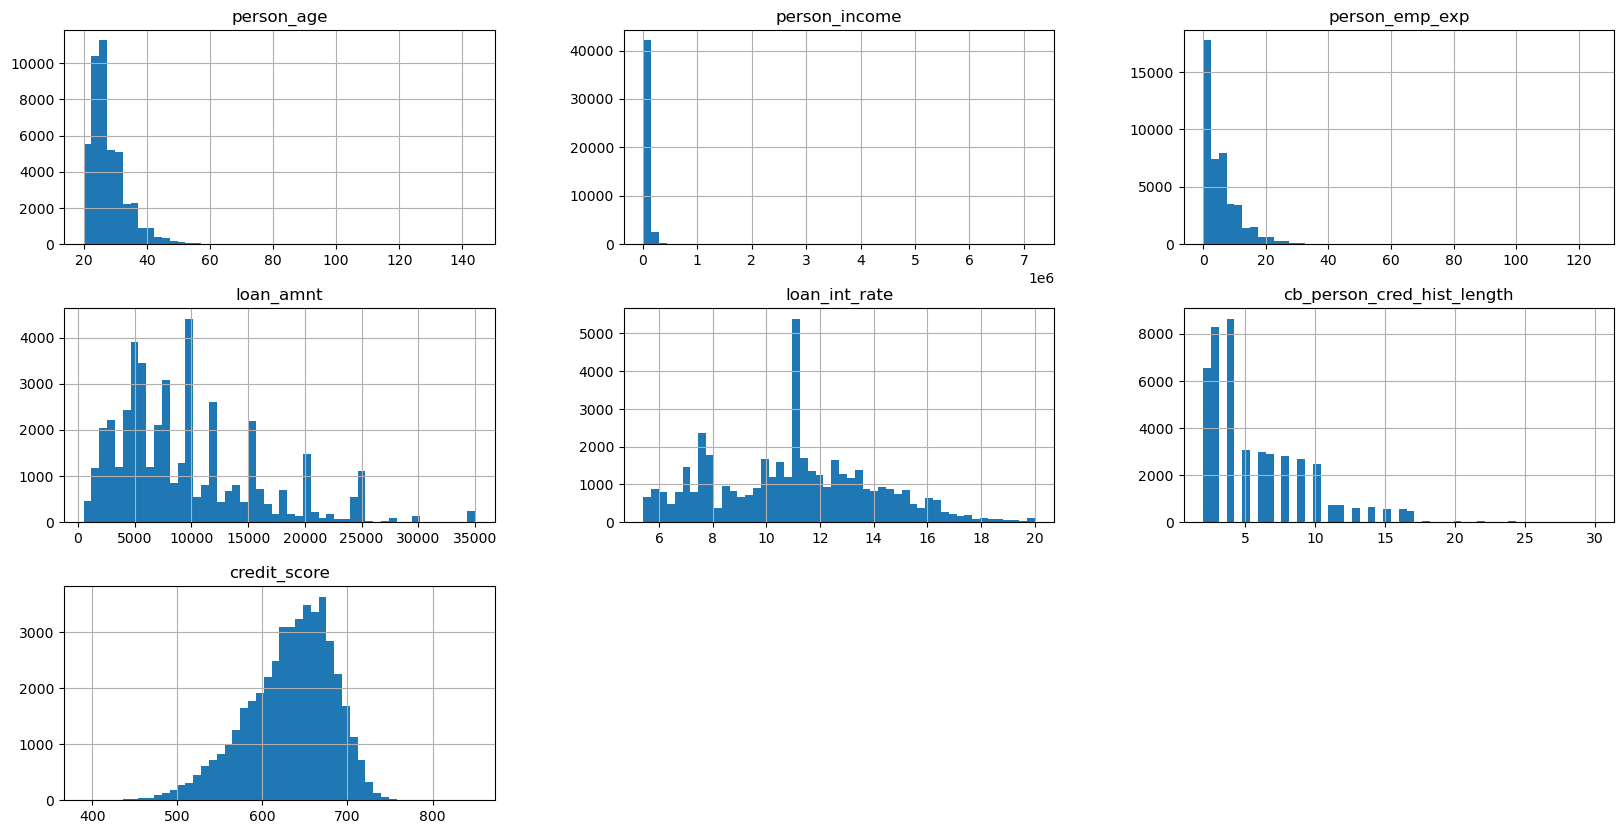

In [12]:
histogram_num_features(data)

Box Plot for Numerical Features


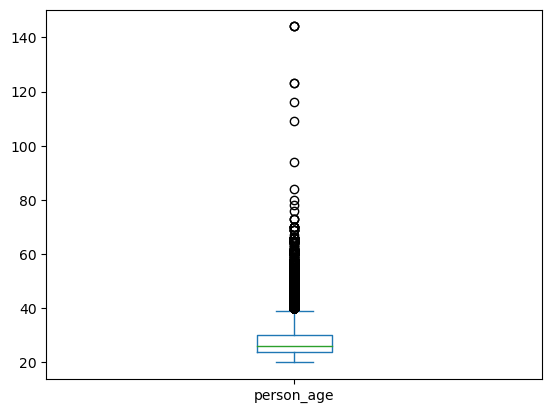

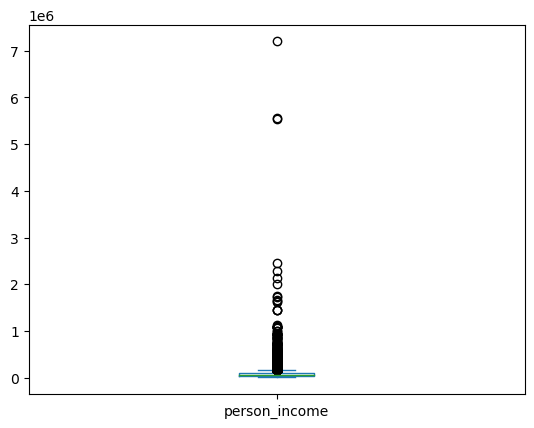

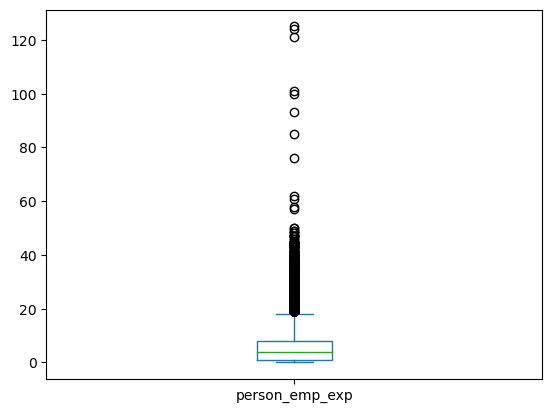

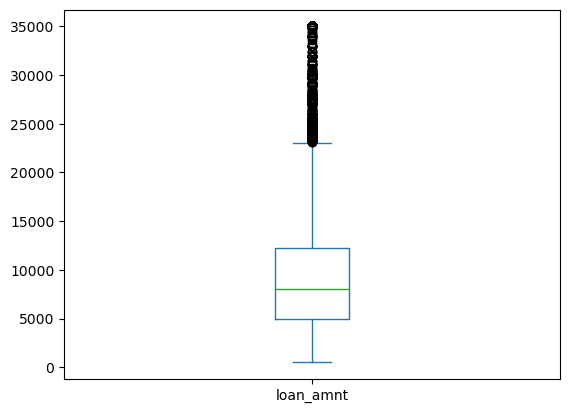

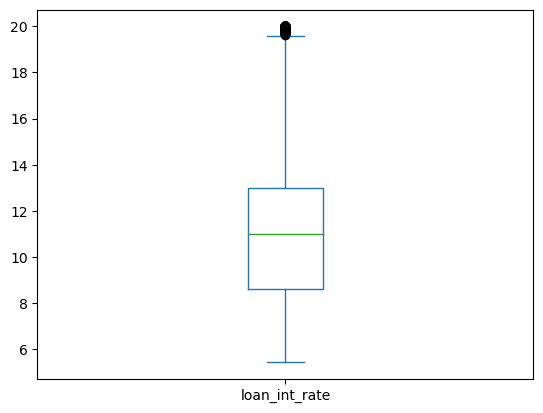

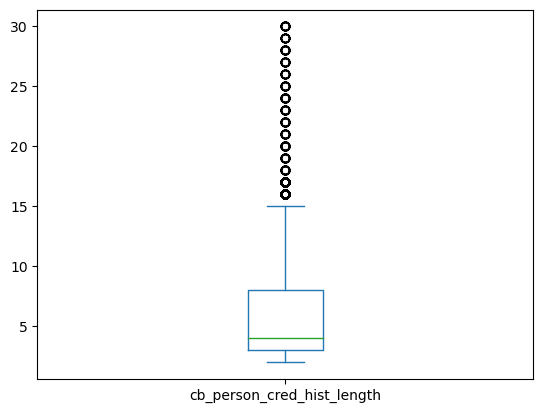

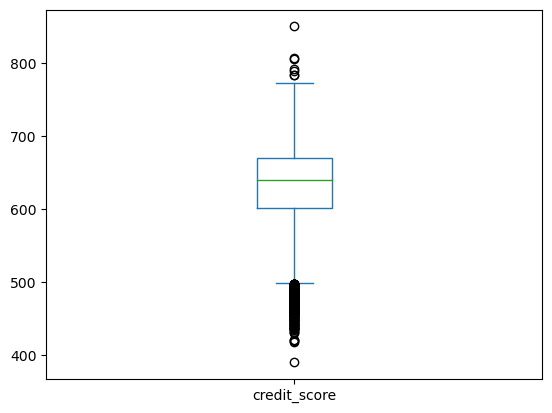

In [13]:
boxplot_num_features(data);

In [14]:
data = data[data['person_age']<=80]
data = data[data['person_income']<=300000]
data = data[data['person_emp_exp']<=60]
data.shape

(44630, 12)

In [15]:
for col in cat_cols[0]:
    print("Distribution of", col)
    display(pd.DataFrame(data[col].value_counts()))

Distribution of person_gender


,count
person_gender,
male,24632
female,19998


Distribution of person_education


,count
person_education,
Bachelor,13294
Associate,11925
High School,11874
Master,6925
Doctorate,612


Distribution of person_home_ownership


,count
person_home_ownership,
RENT,23382
MORTGAGE,18205
OWN,2928
OTHER,115


Distribution of loan_intent


,count
loan_intent,
EDUCATION,9097
MEDICAL,8489
VENTURE,7748
PERSONAL,7476
DEBTCONSOLIDATION,7080
HOMEIMPROVEMENT,4740


In [16]:
def visualize_cat_cols(df):
    print("Bar Plot for Categorical Features")
    for col in cat_cols[0]:
        plt.figure(figsize=(15,10));
        df[col].value_counts().plot(kind='bar');
        plt.title("Bar Plot for "+ str(col));
        plt.show();

Bar Plot for Categorical Features


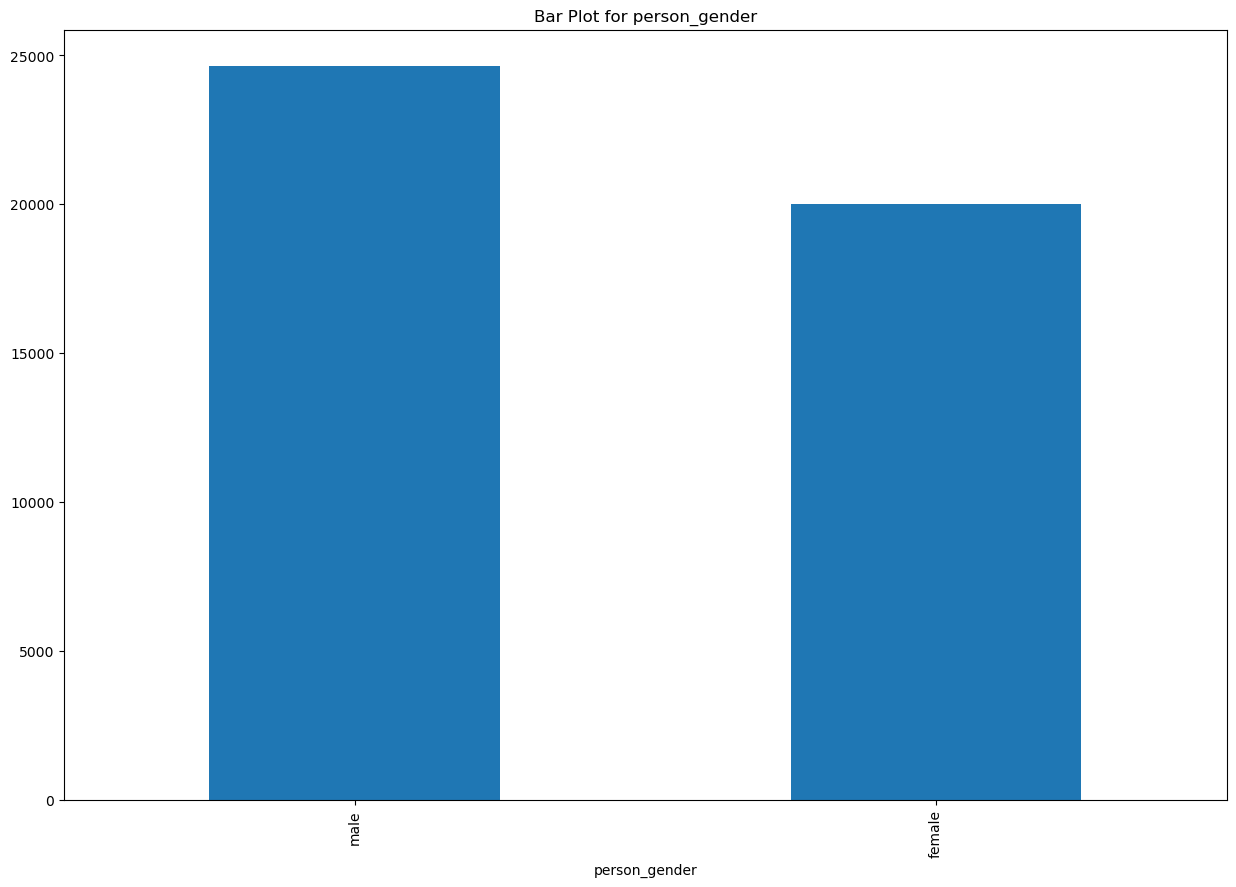

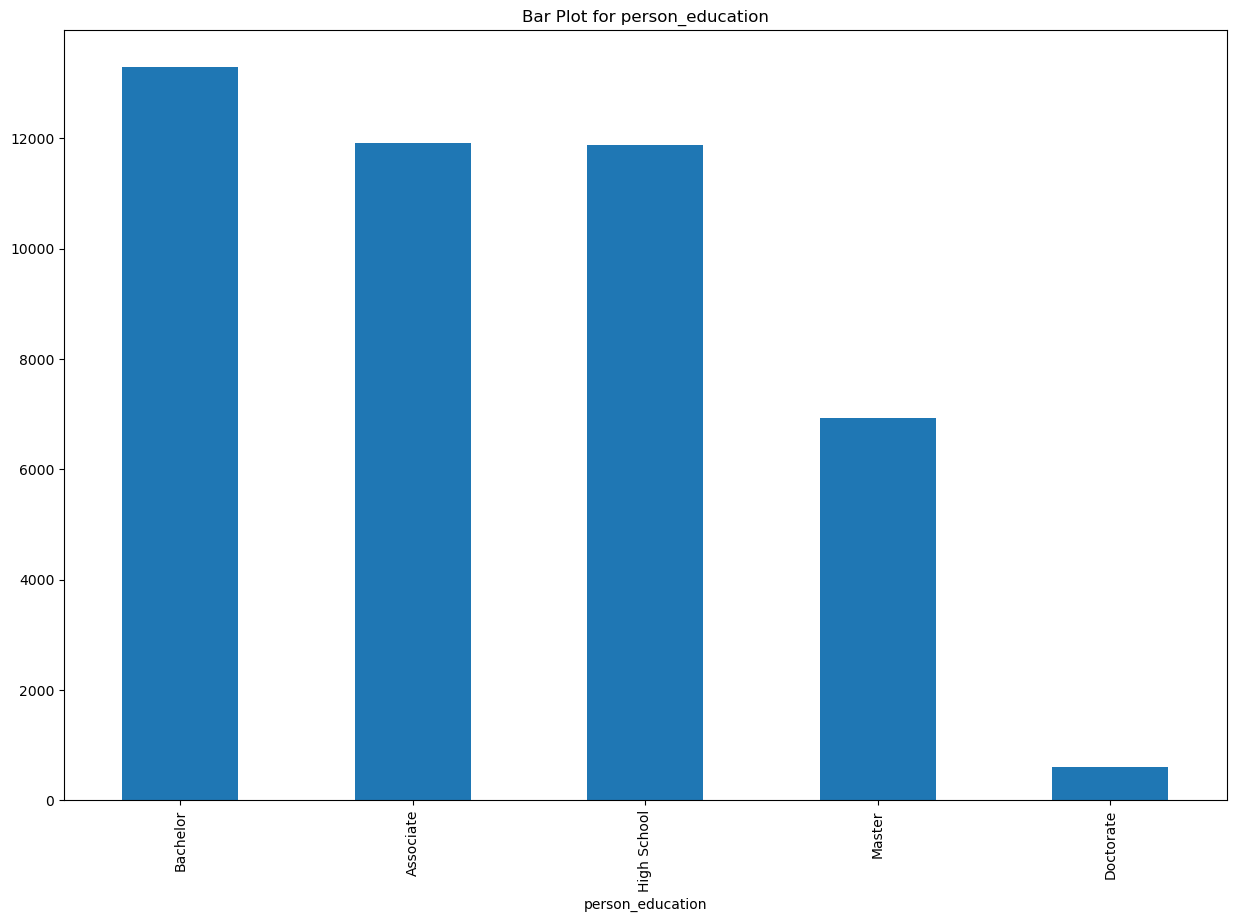

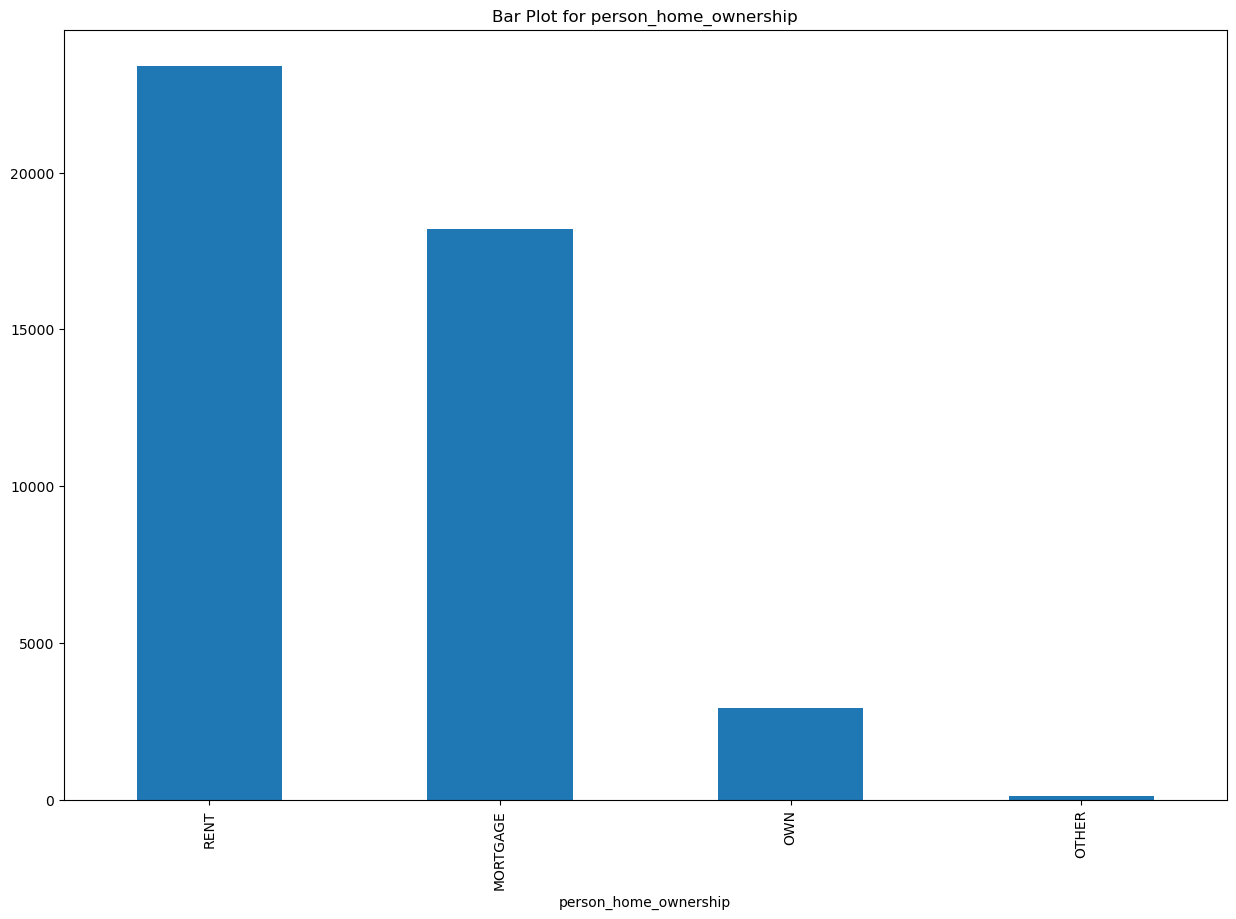

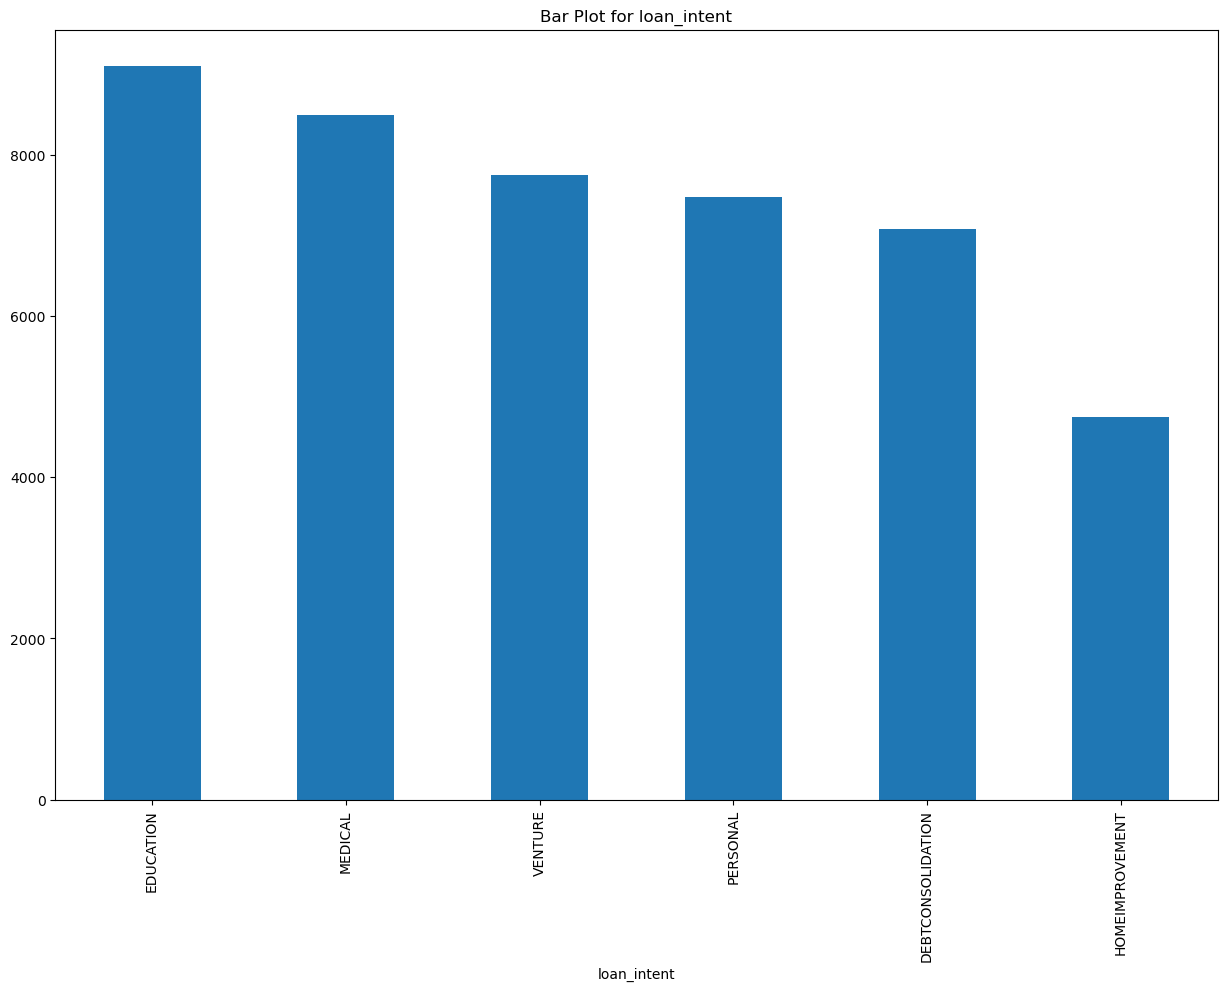

In [17]:
visualize_cat_cols(data)

In [18]:
def crosstabs(df, target):
    if target in cat_cols[0]:
        cat_cols.remove(target)
    for i in cat_cols[0]:
        print("Crosstab between", i, "&", target)
        display(pd.crosstab(df[i], df[target]))

In [19]:
crosstabs(data, "loan_status")

Crosstab between person_gender & loan_status


loan_status,0,1
person_gender,,
female,15529,4469
male,19140,5492


Crosstab between person_education & loan_status


loan_status,0,1
person_education,,
Associate,9282,2643
Bachelor,10285,3009
Doctorate,473,139
High School,9212,2662
Master,5417,1508


Crosstab between person_home_ownership & loan_status


loan_status,0,1
person_home_ownership,,
MORTGAGE,16092,2113
OTHER,76,39
OWN,2707,221
RENT,15794,7588


Crosstab between loan_intent & loan_status


loan_status,0,1
loan_intent,,
DEBTCONSOLIDATION,4926,2154
EDUCATION,7548,1549
HOMEIMPROVEMENT,3484,1256
MEDICAL,6130,2359
PERSONAL,5960,1516
VENTURE,6621,1127


### Dsitribution of Categorical Variables with Target Variable

In [20]:
def categorical_with_target(df, target):
    print("Relationships between categorical features and target variable")
    for col in cat_cols[0]:
        pd.crosstab(data[col], data[target]).plot(kind='bar')

Relationships between categorical features and target variable


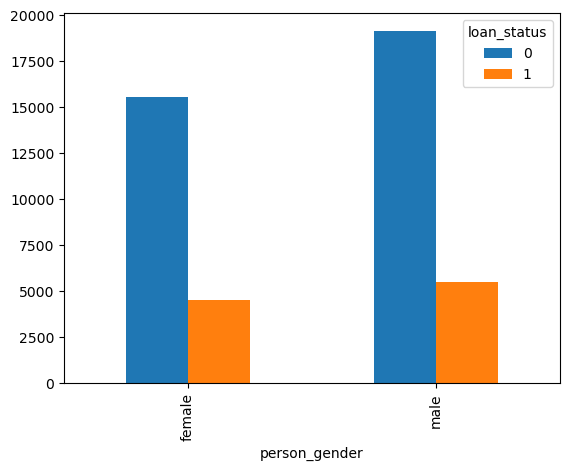

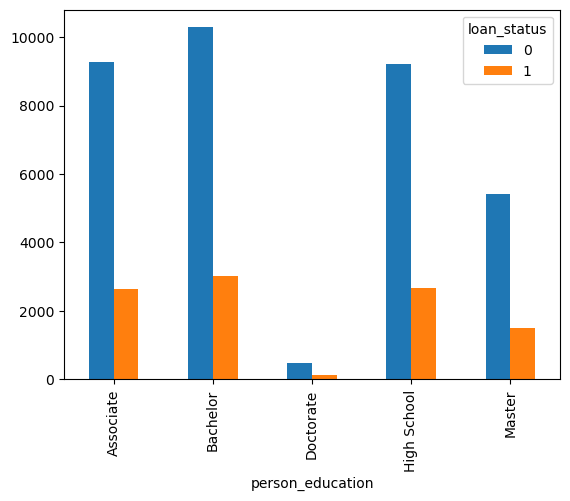

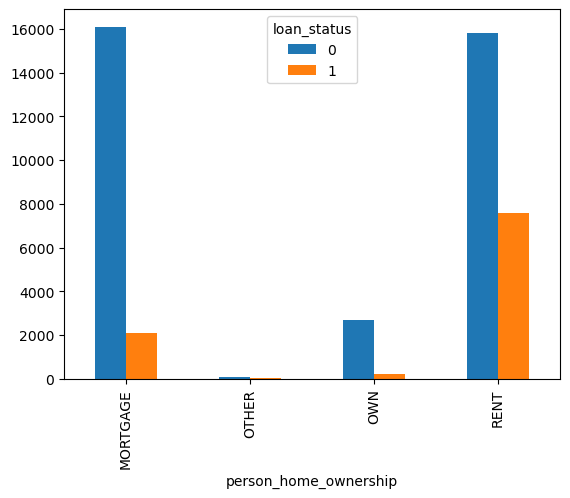

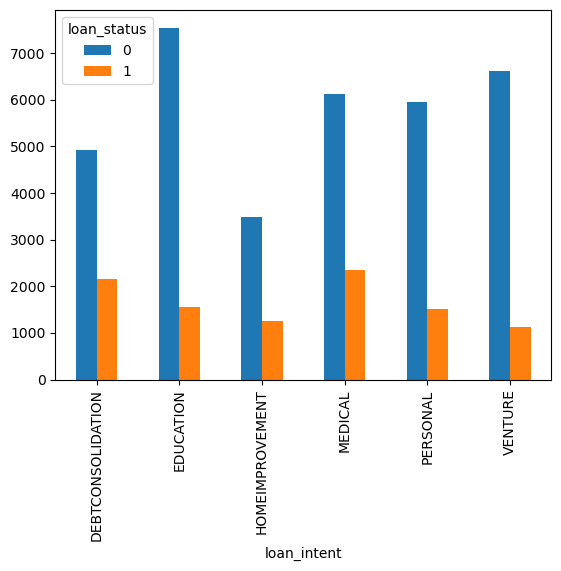

In [21]:
categorical_with_target(data, 'loan_status')

### Dsitribution of Numerical Variables with Target Variable

In [22]:
def numerical_features_with_target(data, col):
    data[data['loan_status']==0][col].plot(kind = 'density');
    data[data['loan_status']==1][col].plot(kind = 'density');
    plt.xlabel(col);
    plt.legend([0,1]);

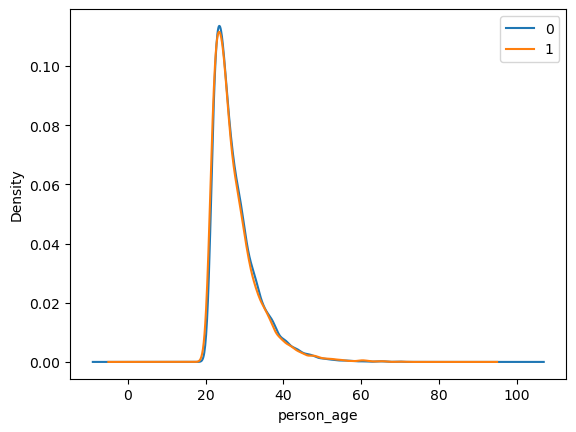

In [23]:
numerical_features_with_target(data, 'person_age')

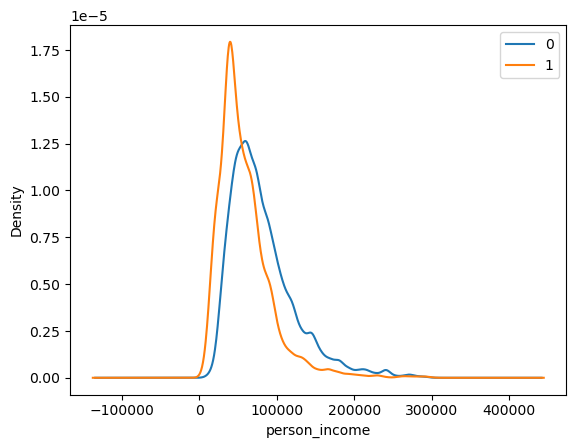

In [24]:
numerical_features_with_target(data, 'person_income')

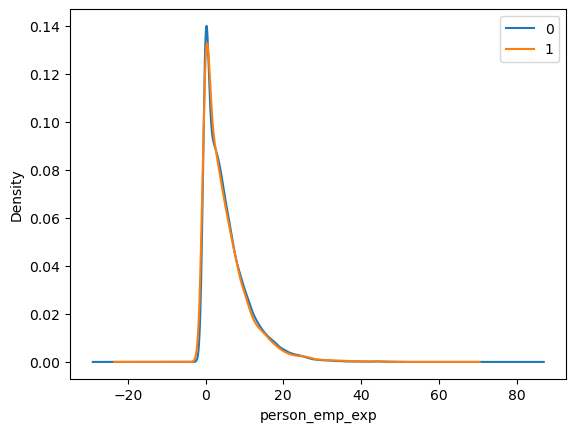

In [25]:
numerical_features_with_target(data, 'person_emp_exp')

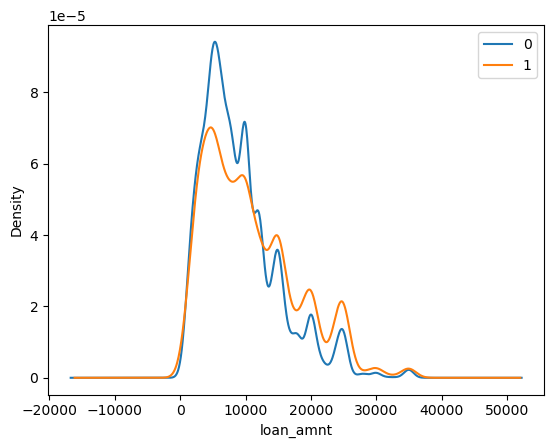

In [26]:
numerical_features_with_target(data, 'loan_amnt')

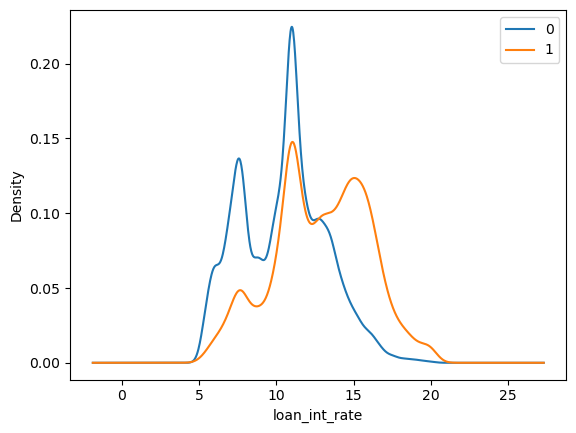

In [27]:
numerical_features_with_target(data, 'loan_int_rate')

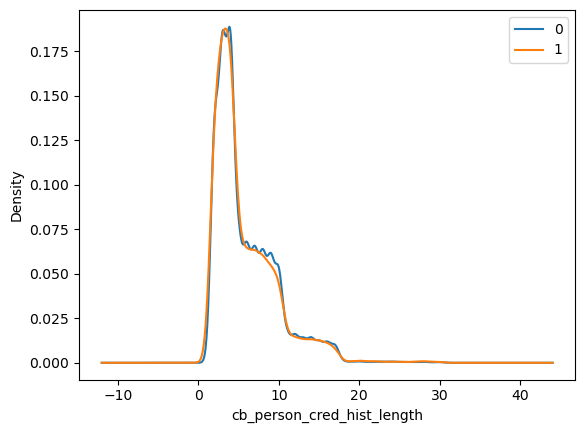

In [28]:
numerical_features_with_target(data, 'cb_person_cred_hist_length')

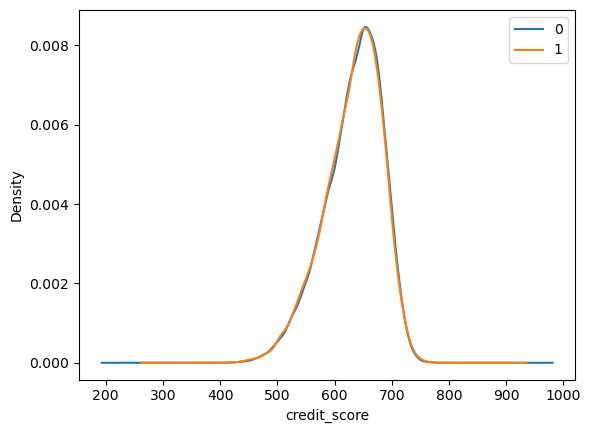

In [29]:
numerical_features_with_target(data, 'credit_score')

### Feature Engineering

#### Demographic Features

In [30]:
# how much has the person been employed out of entire life
data['person_employement_stability'] = data['person_emp_exp'] / data['person_age']
data['person_employement_stability'].describe()

count    44630.000000
mean         0.166172
std          0.144350
min          0.000000
25%          0.041667
50%          0.142857
75%          0.259259
max          0.763158
Name: person_employement_stability, dtype: float64

In [31]:
# ratio of income and loan amount
data['person_financial_stability'] = data['person_income']/data['loan_amnt']
data['person_financial_stability'].describe()

count    44630.000000
mean        11.457141
std         10.907604
min          1.505602
25%          5.291446
50%          8.163497
75%         13.406528
max        241.503000
Name: person_financial_stability, dtype: float64

#### Credit and Loan Features

In [32]:
# Measures how heavily the person relies on credit relative to their income and credit history.
data['credit_utilization_ratio'] = data['loan_amnt'] / (data['person_income'] * data['cb_person_cred_hist_length'])
data['credit_utilization_ratio'].describe()

count    44630.000000
mean         0.034576
std          0.031142
min          0.000319
25%          0.012688
50%          0.024856
75%          0.046141
max          0.310131
Name: credit_utilization_ratio, dtype: float64

In [33]:
# how much is loan amount out of the income
data['person_ltv'] = data['loan_amnt'] / data['person_income']
data['person_ltv'].describe()

count    44630.000000
mean         0.140540
std          0.087041
min          0.004141
25%          0.074591
50%          0.122497
75%          0.188984
max          0.664186
Name: person_ltv, dtype: float64

In [34]:
# how much is their credit usage compared to age
data['person_credit_age_ratio'] = data['cb_person_cred_hist_length'] / data['person_age']
data['person_credit_age_ratio'].describe()

count    44630.000000
mean         0.197368
std          0.089624
min          0.076923
25%          0.130435
50%          0.173913
75%          0.259259
max          0.588235
Name: person_credit_age_ratio, dtype: float64

#### Behavioural Features

In [35]:
# loan amount with interest rate
data['person_interest_rate_adj_risk'] = data['loan_int_rate']/100 * data['loan_amnt']
data['person_interest_rate_adj_risk'].describe()

count    44630.000000
mean      1074.144314
std        846.469920
min         48.800000
25%        481.500000
50%        825.750000
75%       1406.793750
max       7000.000000
Name: person_interest_rate_adj_risk, dtype: float64

#### Combined Features


In [36]:
# income with experience
data['person_income_stability'] = data['person_income'] * data['person_emp_exp']
data['person_income_stability'].describe()

count    4.463000e+04
mean     4.321281e+05
std      6.043306e+05
min      0.000000e+00
25%      5.430450e+04
50%      2.348460e+05
75%      5.697788e+05
max      1.085067e+07
Name: person_income_stability, dtype: float64

In [37]:
# income credit history
data['person_income_credit_history'] = data['person_income'] / data['cb_person_cred_hist_length']
data['person_income_credit_history'].describe()

count     44630.000000
mean      18165.118035
std       14375.387514
min         285.714286
25%        8160.395833
50%       14333.250000
75%       23938.687500
max      144453.500000
Name: person_income_credit_history, dtype: float64

In [38]:
# repayment capacity of person based on income and loan amount with interest
data['debt_repayment_capacity'] = data['person_income'] - (data['loan_amnt'] * data['loan_int_rate']/100)
data['debt_repayment_capacity'].describe()

count     44630.000000
mean      75413.517685
std       41974.390549
min        7533.875000
25%       46216.025000
50%       65846.000000
75%       93276.450000
max      295730.500000
Name: debt_repayment_capacity, dtype: float64

### Visualizing New Features

In [39]:
new_features = ['person_employement_stability',
       'person_financial_stability', 'credit_utilization_ratio', 'person_ltv',
       'person_credit_age_ratio', 'person_interest_rate_adj_risk',
       'person_income_stability', 'person_income_credit_history',
       'debt_repayment_capacity']

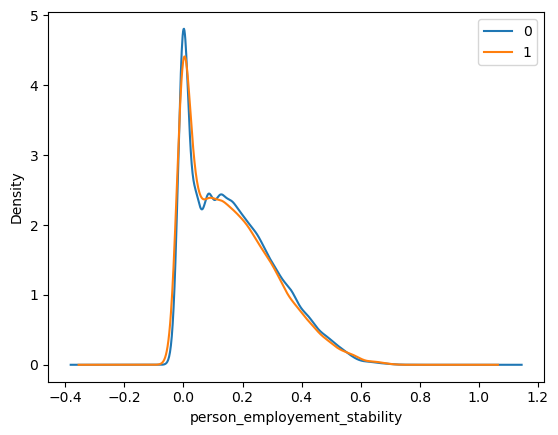

In [40]:
numerical_features_with_target(data, 'person_employement_stability')

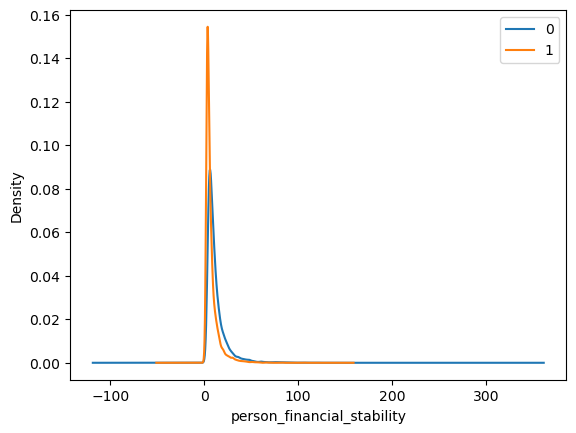

In [41]:
numerical_features_with_target(data, 'person_financial_stability')

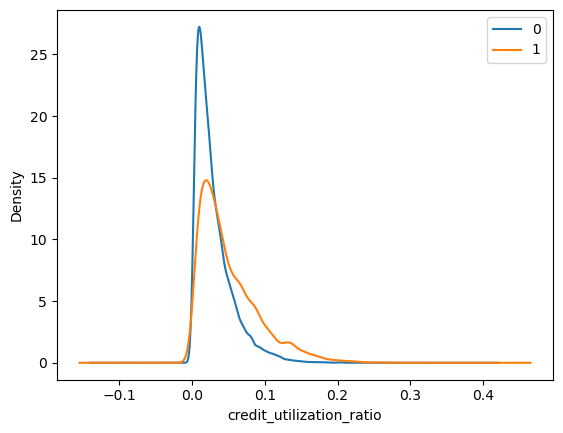

In [42]:
numerical_features_with_target(data, 'credit_utilization_ratio')

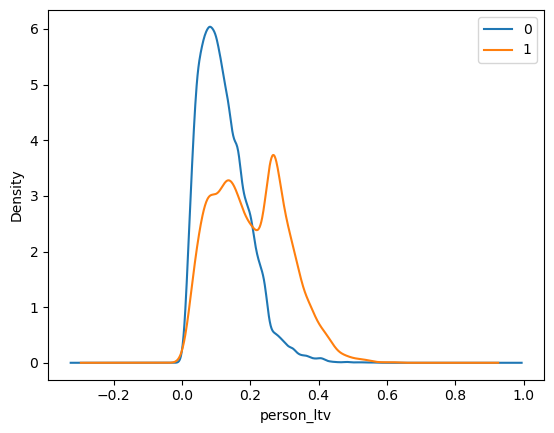

In [43]:
numerical_features_with_target(data, 'person_ltv')

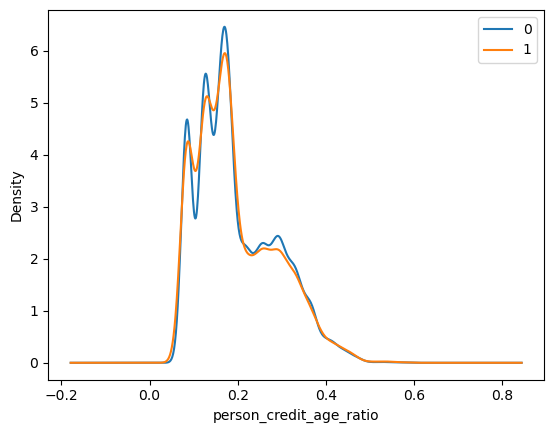

In [44]:
numerical_features_with_target(data, 'person_credit_age_ratio')

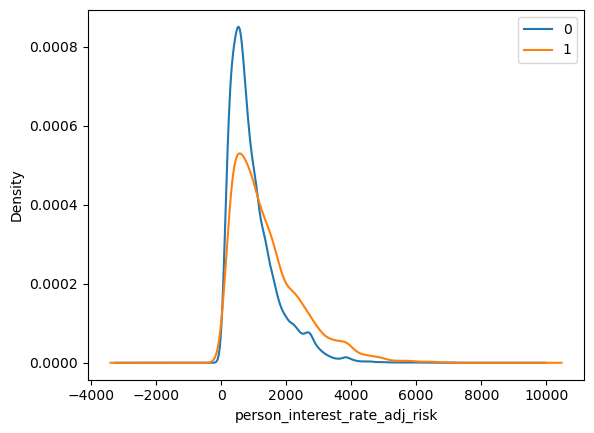

In [45]:
numerical_features_with_target(data, 'person_interest_rate_adj_risk')

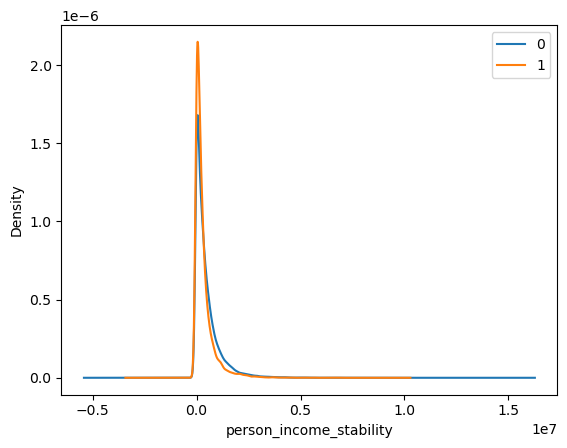

In [46]:
numerical_features_with_target(data, 'person_income_stability')

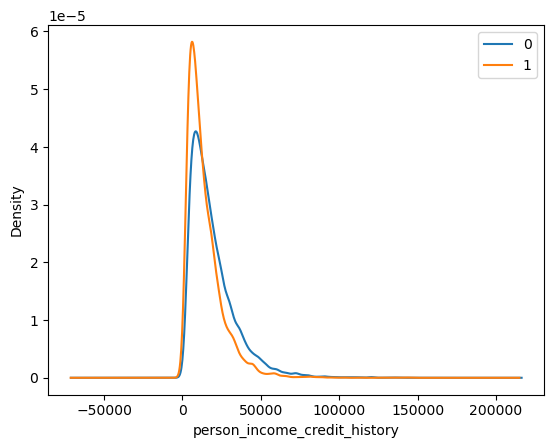

In [47]:
numerical_features_with_target(data, 'person_income_credit_history')

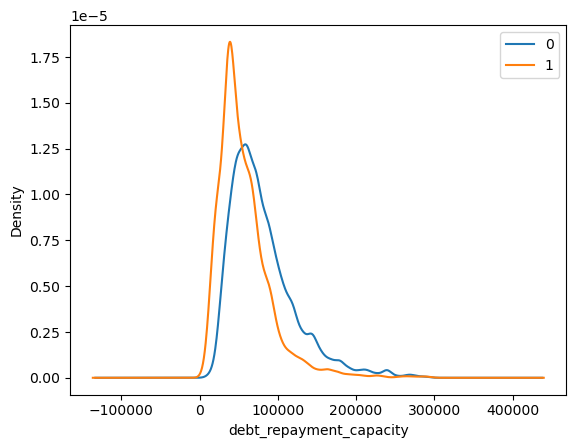

In [48]:
numerical_features_with_target(data, 'debt_repayment_capacity')

In [49]:
data.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,cb_person_cred_hist_length,credit_score,loan_status,person_employement_stability,person_financial_stability,credit_utilization_ratio,person_ltv,person_credit_age_ratio,person_interest_rate_adj_risk,person_income_stability,person_income_credit_history,debt_repayment_capacity
0,22,female,Master,71948,0,RENT,35000,PERSONAL,16.02,3,561,1,0.000000,2.055657,0.162154,0.486462,0.136364,5607.00,0,23982.666667,66341.00
1,21,female,High School,12282,0,OWN,1000,EDUCATION,11.14,2,504,0,0.000000,12.282000,0.040710,0.081420,0.095238,111.40,0,6141.000000,12170.60
2,25,female,High School,12438,3,MORTGAGE,5500,MEDICAL,12.87,3,635,1,0.120000,2.261455,0.147398,0.442193,0.120000,707.85,37314,4146.000000,11730.15
3,23,female,Bachelor,79753,0,RENT,35000,MEDICAL,15.23,2,675,1,0.000000,2.278657,0.219427,0.438855,0.086957,5330.50,0,39876.500000,74422.50
4,24,male,Master,66135,1,RENT,35000,MEDICAL,14.27,4,586,1,0.041667,1.889571,0.132305,0.529221,0.166667,4994.50,66135,16533.750000,61140.50


In [50]:
final_num_cols = num_cols[0][:-1] + new_features
final_num_cols

['person_age',
 'person_income',
 'person_emp_exp',
 'loan_amnt',
 'loan_int_rate',
 'cb_person_cred_hist_length',
 'credit_score',
 'person_employement_stability',
 'person_financial_stability',
 'credit_utilization_ratio',
 'person_ltv',
 'person_credit_age_ratio',
 'person_interest_rate_adj_risk',
 'person_income_stability',
 'person_income_credit_history',
 'debt_repayment_capacity']

In [51]:
cat_cols[0]

['person_gender', 'person_education', 'person_home_ownership', 'loan_intent']

### Calculation WOE and IV for all values

In [52]:
df = pd.crosstab(data['person_gender'], data['loan_status'])
df.columns = ['Non-Event', 'Event']
df['Non-Event%'] = (df['Non-Event'] / sum(df['Non-Event']))*100
df['Event%'] = (df['Event'] / sum(df['Event']))*100
df['WOE'] = np.log(df['Non-Event%']/df['Event%'])
df['IV'] = (df['Non-Event%'] - df['Event%']) * df['WOE']
df = df.reset_index()
df = df.rename(columns={'person_gender' : 'Variable'})
df

,Variable,Non-Event,Event,Non-Event%,Event%,WOE,IV
0,female,15529,4469,44.792177,44.864973,-0.001624,0.000118
1,male,19140,5492,55.207823,55.135027,0.001319,0.000096


In [53]:
final_categorical_woe = pd.DataFrame()
for col in cat_cols[0]:
    df = pd.crosstab(data[col], data['loan_status'])
    df.columns = ['Non-Event', 'Event']
    df['Non-Event%'] = df['Non-Event'] / sum(df['Non-Event'])
    df['Event%'] = df['Event'] / sum(df['Event'])
    df['WOE'] = np.log(df['Non-Event%']/df['Event%'])
    df['IV'] = (df['Non-Event%'] - df['Event%']) * df['WOE']
    df = df.reset_index()
    df = df.rename(columns={col : 'value'})
    df['feature'] = col
    final_categorical_woe = pd.concat([final_categorical_woe, df], ignore_index=True)
    final_categorical_woe = final_categorical_woe[['feature','value','Non-Event','Event','Non-Event%','Event%','WOE','IV']]

In [54]:
final_categorical_woe

,feature,value,Non-Event,Event,Non-Event%,Event%,WOE,IV
0,person_gender,female,15529,4469,0.447922,0.448650,-0.001624,1.182115e-06
1,person_gender,male,19140,5492,0.552078,0.551350,0.001319,9.605064e-07
2,person_education,Associate,9282,2643,0.267732,0.265335,0.008994,2.156008e-05
3,person_education,Bachelor,10285,3009,0.296663,0.302078,-0.018090,9.796272e-05
4,person_education,Doctorate,473,139,0.013643,0.013954,-0.022547,7.014590e-06
5,person_education,High School,9212,2662,0.265713,0.267242,-0.005739,8.777281e-06
6,person_education,Master,5417,1508,0.156249,0.151390,0.031589,1.534828e-04
7,person_home_ownership,MORTGAGE,16092,2113,0.464161,0.212127,0.783045,1.973538e-01
8,person_home_ownership,OTHER,76,39,0.002192,0.003915,-0.579997,9.993979e-04
9,person_home_ownership,OWN,2707,221,0.078081,0.022187,1.258265,7.033042e-02


In [55]:
categorical_mapping = {feature : dict(zip(final_categorical_woe['value'], final_categorical_woe['WOE'])) for feature in final_categorical_woe['feature']}
categorical_mapping

{'person_gender': {'female': -0.0016238741017432865,
  'male': 0.0013194503816025317,
  'Associate': 0.008993957459351252,
  'Bachelor': -0.0180897222804685,
  'Doctorate': -0.02254699237623977,
  'High School': -0.005739185751962044,
  'Master': 0.031589439352516596,
  'MORTGAGE': 0.7830450677161411,
  'OTHER': -0.5799967535807964,
  'OWN': 1.2582651403590674,
  'RENT': -0.5141063787348594,
  'DEBTCONSOLIDATION': -0.41996772677333166,
  'EDUCATION': 0.3365046183340913,
  'HOMEIMPROVEMENT': -0.2269194567932315,
  'MEDICAL': -0.2922114982148989,
  'PERSONAL': 0.1218267461195975,
  'VENTURE': 0.5235187331475889},
 'person_education': {'female': -0.0016238741017432865,
  'male': 0.0013194503816025317,
  'Associate': 0.008993957459351252,
  'Bachelor': -0.0180897222804685,
  'Doctorate': -0.02254699237623977,
  'High School': -0.005739185751962044,
  'Master': 0.031589439352516596,
  'MORTGAGE': 0.7830450677161411,
  'OTHER': -0.5799967535807964,
  'OWN': 1.2582651403590674,
  'RENT': -0.5

In [56]:
for i in categorical_mapping:
    data[i] = data[i].map(categorical_mapping[i])

In [57]:
final_numerical_woe = pd.DataFrame()
for col in final_num_cols:
    opt = OptimalBinning(name = col, dtype='numerical', solver='cp')
    opt.fit(data[col], data['loan_status'])
    bin_table = opt.binning_table
    final_table = bin_table.build()
    final_table['feature'] = col
    final_numerical_woe = pd.concat([final_numerical_woe,final_table], ignore_index=True)
    final_numerical_woe = final_numerical_woe[~final_numerical_woe['Bin'].isin(['Special','Missing',''])]

final_numerical_woe

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,feature
0,"(-inf, 22.50)",5540,0.124132,4093,1447,0.261191,-0.207383,5.642298e-03,7.040261e-04,person_age
1,"[22.50, 23.50)",5245,0.117522,4066,1179,0.224786,-0.009175,9.918949e-06,1.239864e-06,person_age
2,"[23.50, 25.50)",9624,0.215640,7469,2155,0.223919,-0.004198,3.804769e-06,4.755957e-07,person_age
3,"[25.50, 29.50)",11857,0.265673,9299,2558,0.215738,0.043513,4.969503e-04,6.211388e-05,person_age
4,"[29.50, 31.50)",3603,0.080730,2829,774,0.214821,0.048938,1.907239e-04,2.383810e-05,person_age
5,"[31.50, 34.50)",3567,0.079924,2840,727,0.203813,0.115464,1.031435e-03,1.288578e-04,person_age
6,"[34.50, 38.50)",2701,0.060520,2130,571,0.211403,0.06932,2.852232e-04,3.564576e-05,person_age
7,"[38.50, inf)",2493,0.055859,1943,550,0.220618,0.014902,1.235301e-05,1.544111e-06,person_age
8,"(-inf, 28298.00)",2232,0.050011,797,1435,0.642921,-1.835234,2.221973e-01,2.443410e-02,person_income
9,"[28298.00, 42609.50)",6311,0.141407,3857,2454,0.388845,-0.794998,1.074111e-01,1.308363e-02,person_income


In [58]:
lower_limit, upper_limit = [], []

for i in final_numerical_woe['Bin']:
    lower_limit.append(float(re.sub(r'[\[\](){}<>]', '', i.split(',')[0].strip())))
    upper_limit.append(float(re.sub(r'[\[\](){}<>]', '', i.split(',')[1].strip())))
    
final_numerical_woe['lower_limit'] = lower_limit
final_numerical_woe['upper_limit'] = upper_limit

In [59]:
def replace_numerical_with_woe(data, row, feature):
    for idx,i in data.iterrows():
        if i['feature'] == feature and i['lower_limit'] < row[feature] <= i['upper_limit']:
            return i['WoE']
        
    return None

In [60]:
for col in final_num_cols:
    data[col] = data.apply(lambda row : replace_numerical_with_woe(final_numerical_woe, row, col), axis =1)

### Feature Selection with Correlation Matrix

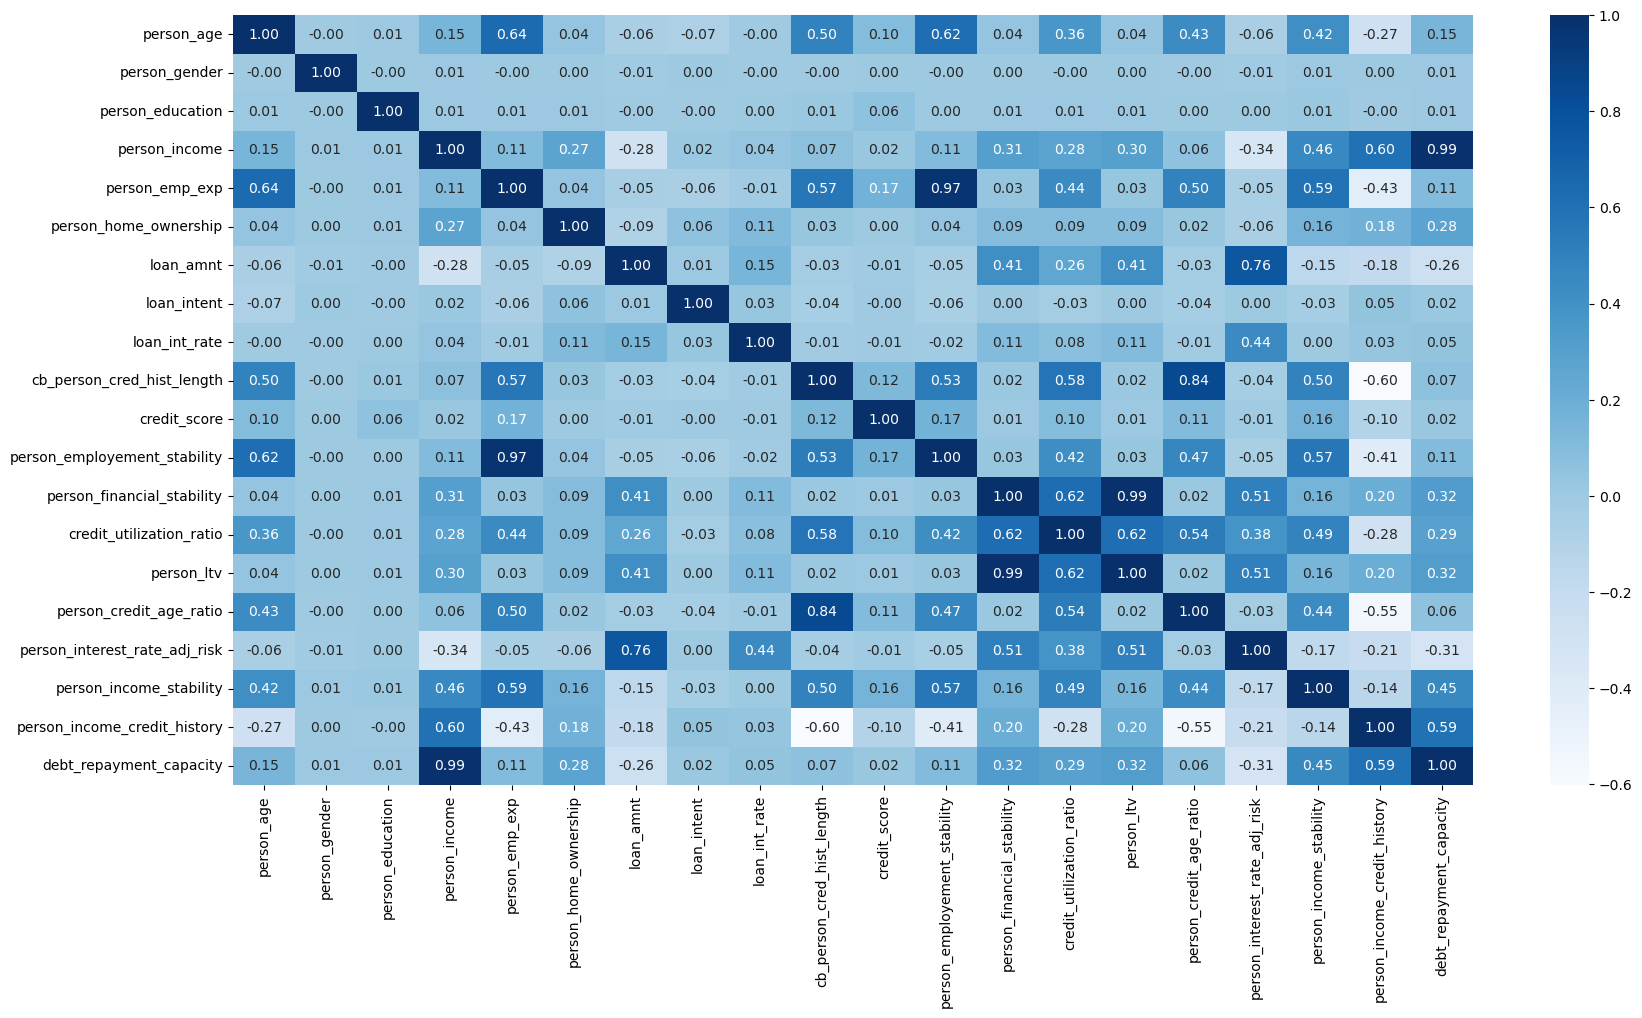

In [61]:
plt.figure(figsize=(20,10));
sns.heatmap(data.drop(['loan_status'],axis=1).corr(), annot=True, cmap='Blues', fmt='.2f');

In [62]:
correlation_matrix = data.drop(['loan_status'],axis=1).corr().abs()

upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
upper_triangle_df = correlation_matrix.where(upper_triangle)

In [63]:
high_corr = [col for col in upper_triangle_df.columns if any(upper_triangle_df[col] > 0.7)]
high_corr

['person_employement_stability',
 'person_ltv',
 'person_credit_age_ratio',
 'person_interest_rate_adj_risk',
 'debt_repayment_capacity']

### Feature Selection with IV

In [64]:
cat_feat_iv = final_categorical_woe.groupby(['feature']).agg({'IV' : 'sum'})
# cat_feat_iv.sort_values(by=['IV'], ascending=False)

In [65]:
num_feat_iv = final_numerical_woe.groupby(['feature']).agg({'IV' : 'sum'})
# num_feat_iv.sort_values(by=['IV'], ascending=False)

In [66]:
all_features_iv = pd.concat([cat_feat_iv, num_feat_iv]).reset_index()
# all_features_iv.sort_values(by=['IV'], ascending=False)

In [67]:
iv_selected_features = all_features_iv[all_features_iv['IV']>=0.02]
iv_selected_features.sort_values(by=['IV'], ascending=False)

,feature,IV
14,person_financial_stability,0.970854
19,person_ltv,0.970854
9,loan_int_rate,0.735100
7,debt_repayment_capacity,0.590968
15,person_income,0.571539
3,person_home_ownership,0.426106
6,credit_utilization_ratio,0.406728
18,person_interest_rate_adj_risk,0.234682
16,person_income_credit_history,0.217048
0,loan_intent,0.118572


### Feature Selection with Decision Tree Importances

In [68]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=42)
X = data.drop(['loan_status'], axis = 1)
y = data['loan_status']

dtc.fit(X,y)

dtc_features_importances = pd.DataFrame({'feature' : dtc.feature_names_in_,
                                         'Feature Importances' : dtc.feature_importances_})

dtc_features_importances = dtc_features_importances.sort_values(by=['Feature Importances'], ascending=False).head(10)
dtc_features_importances

,feature,Feature Importances
12,person_financial_stability,0.207810
8,loan_int_rate,0.140100
5,person_home_ownership,0.137622
7,loan_intent,0.069029
19,debt_repayment_capacity,0.045194
6,loan_amnt,0.038799
0,person_age,0.038128
10,credit_score,0.038010
2,person_education,0.032582
3,person_income,0.029513


### Feature Selection with RFE

In [69]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

base_model = LogisticRegression(random_state=42, max_iter=1000)

rfe = RFE(estimator=base_model, n_features_to_select= 10)
rfe.fit(X,y)
rfe_features = X.columns[rfe.support_].to_list()

rfe_selected_features = pd.DataFrame({'feature' : rfe_features, 'RFE' : True})
rfe_selected_features

,feature,RFE
0,person_income,True
1,person_home_ownership,True
2,loan_amnt,True
3,loan_intent,True
4,loan_int_rate,True
5,cb_person_cred_hist_length,True
6,credit_score,True
7,person_financial_stability,True
8,person_interest_rate_adj_risk,True
9,debt_repayment_capacity,True


In [70]:
final_features_selection_matrix = pd.merge(iv_selected_features, dtc_features_importances, on='feature', how='left')
final_features_selection_matrix = pd.merge(final_features_selection_matrix, rfe_selected_features, on='feature', how='left')
final_features_selection_matrix.sort_values(by=['IV','Feature Importances'], ascending=False)

,feature,IV,Feature Importances,RFE
6,person_financial_stability,0.970854,0.207810,True
11,person_ltv,0.970854,NaN,NaN
5,loan_int_rate,0.735100,0.140100,True
3,debt_repayment_capacity,0.590968,0.045194,True
7,person_income,0.571539,0.029513,True
1,person_home_ownership,0.426106,0.137622,True
2,credit_utilization_ratio,0.406728,NaN,NaN
10,person_interest_rate_adj_risk,0.234682,NaN,True
8,person_income_credit_history,0.217048,NaN,NaN
0,loan_intent,0.118572,0.069029,True


### Selecting best features from all methods 

In [71]:
keep_features = ['person_financial_stability','loan_int_rate', 'debt_repayment_capacity','person_home_ownership',
                 'credit_utilization_ratio','person_interest_rate_adj_risk','person_income_credit_history','loan_intent', 
                 'loan_status']

len(keep_features)

9

In [72]:
filtered_data = data[keep_features]
filtered_data.shape

(44630, 9)

In [73]:
filtered_data.head()

,person_financial_stability,loan_int_rate,debt_repayment_capacity,person_home_ownership,credit_utilization_ratio,person_interest_rate_adj_risk,person_income_credit_history,loan_intent,loan_status
0,-2.26648,-1.807712,0.064429,-0.514106,-1.421671,-1.209731,0.184546,0.121827,1
1,0.67791,0.204038,-1.861388,1.258265,-0.206738,0.587718,-0.286190,0.336505,0
2,-2.26648,-0.077573,-1.861388,0.783045,-1.421671,0.363266,-0.519846,-0.292211,1
3,-2.26648,-1.205712,0.494080,-0.514106,-1.421671,-1.209731,0.803770,-0.292211,1
4,-2.26648,-0.461133,0.064429,-0.514106,-1.421671,-1.209731,0.113622,-0.292211,1


### Train Test Split

In [74]:
X = filtered_data.drop(['loan_status'], axis =1)
y = filtered_data['loan_status']

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape

((35704, 8), (8926, 8))

### Train All Base Models

In [76]:
def check_all_models(X_train, X_test, y_train, y_test):
    models = {
            'Logistic Regression': LogisticRegression(),
            'K-Nearest Neighbors': KNeighborsClassifier(),
            'Naive Bayes': GaussianNB(),
            'Decision Tree': DecisionTreeClassifier(),
            'Random Forest': RandomForestClassifier(),
            'Support Vector Machine': SVC(probability=True),
            'Gradient Boosting': GradientBoostingClassifier(),
            'AdaBoost': AdaBoostClassifier(),
            'XGBoost': XGBClassifier(),
            'XGBoostRandomForest': XGBRFClassifier(),
            'LightGBM': LGBMClassifier(verbose=-1),
            'CatBoost': CatBoostClassifier(verbose=0)
        }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:,1]
        test_acc = accuracy_score(y_test, y_pred)
        test_prec = precision_score(y_test, y_pred, average='weighted')
        test_rec = recall_score(y_test, y_pred, average='weighted')
        test_f1 = f1_score(y_test, y_pred, average='weighted')
        test_auc = roc_auc_score(y_test, y_prob)

        results.append({
            'Model' : name,
            'Test Accuracy' : test_acc,
            'Test Precision' : test_prec,
            'Test Recall' : test_rec,
            'Test F1-Score' : test_f1,
            'Test AUC Score' : test_auc
        })

    model_results_df = pd.DataFrame(results)
    display(model_results_df)

In [77]:
check_all_models(X_train, X_test, y_train, y_test )

,Model,Test Accuracy,Test Precision,Test Recall,Test F1-Score,Test AUC Score
0,Logistic Regression,0.868922,0.862634,0.868922,0.862069,0.882071
1,K-Nearest Neighbors,0.881358,0.876555,0.881358,0.876529,0.869548
2,Naive Bayes,0.847188,0.847629,0.847188,0.847405,0.863150
3,Decision Tree,0.857047,0.855954,0.857047,0.856475,0.799999
4,Random Forest,0.892113,0.888325,0.892113,0.888208,0.901099
5,Support Vector Machine,0.890881,0.888177,0.890881,0.884134,0.859507
6,Gradient Boosting,0.892785,0.889992,0.892785,0.886576,0.911757
7,AdaBoost,0.866906,0.860730,0.866906,0.861505,0.888901
8,XGBoost,0.898835,0.896472,0.898835,0.893428,0.912936
9,XGBoostRandomForest,0.890993,0.887403,0.890993,0.885531,0.899404


### Fine Tuning XGBModel and Model Performance Metrics

In [78]:
from sklearn.model_selection import RandomizedSearchCV
xgb_model = XGBClassifier()

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],                        # Learning rate
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],                              # Max depth of each tree
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],                 # Minimum sum of instance weight
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],                         # Fraction of samples for each tree
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],                  # Fraction of features per tree
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],      # Minimum loss reduction
    'scale_pos_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],                 # Balance for imbalanced classes
}

random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=param_dist,
                                   n_iter=50,
                                   scoring='f1',
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1
                                  )

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Model Parameters:",best_params)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Model Parameters: {'subsample': 0.6, 'scale_pos_weight': 2, 'n_estimators': 700, 'min_child_weight': 6, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 1.0}

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      6934
           1       0.79      0.71      0.74      1992

    accuracy                           0.89      8926
   macro avg       0.85      0.83      0.84      8926
weighted avg       0.89      0.89      0.89      8926


Confusion Matrix:
[[6553  381]
 [ 584 1408]]


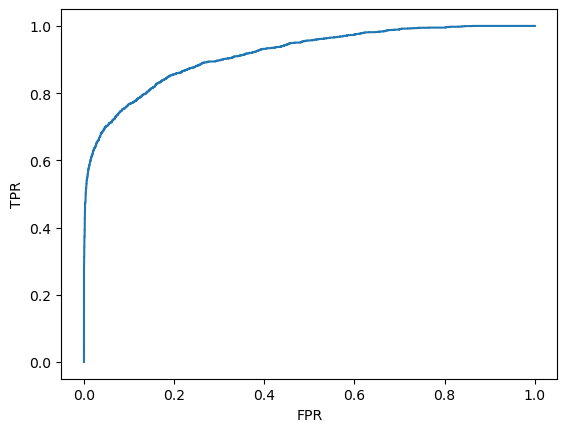

In [79]:
from sklearn.metrics import roc_curve

tpr, fpr, _ = roc_curve(y_test, y_proba)
plt.plot(tpr, fpr);
plt.xlabel("FPR");
plt.ylabel("TPR");

In [80]:
pred_proba = best_model.predict_proba(X_train)[:,1]
ks_data = X_train.copy()
ks_data['pred_proba'] = pred_proba
ks_data['Event'] = y_train
ks_data['Non_Event'] = np.where(ks_data['Event'] == 0, 1, 0)

ks_data = ks_data.sort_values(by=['pred_proba'], ascending=False)
ks_data['deciles'] = pd.qcut(ks_data['pred_proba'], q=10, labels=False) + 1

grouped_ks_data = ks_data.groupby(['deciles']).agg({'pred_proba' : ['min','max'],
                                                    'Event' : 'sum',
                                                    'Non_Event' : 'sum'})

grouped_ks_data.columns = ['pred_proba_min','pred_proba_max','Event','Non_Event']
grouped_ks_data = grouped_ks_data.sort_values(by=['deciles'], ascending=False)
grouped_ks_data['Event_Rate'] = (grouped_ks_data['Event'] / grouped_ks_data['Event'].sum())*100
grouped_ks_data['Non_Event_Rate'] = (grouped_ks_data['Non_Event'] / grouped_ks_data['Non_Event'].sum())*100

grouped_ks_data['Cum_Event_Rate'] = np.cumsum(grouped_ks_data['Event_Rate'])
grouped_ks_data['Cum_NonEvent_Rate'] = np.cumsum(grouped_ks_data['Non_Event_Rate'])

grouped_ks_data['KS'] = round(grouped_ks_data['Cum_Event_Rate'] - grouped_ks_data['Cum_NonEvent_Rate'],2)
display(grouped_ks_data)
print('KS Statistic:', grouped_ks_data['KS'].max())

,pred_proba_min,pred_proba_max,Event,Non_Event,Event_Rate,Non_Event_Rate,Cum_Event_Rate,Cum_NonEvent_Rate,KS
deciles,,,,,,,,,
10,0.945305,0.998120,3542,29,44.447233,0.104561,44.447233,0.104561,44.34
9,0.492008,0.945266,2370,1200,29.740243,4.326663,74.187476,4.431224,69.76
8,0.281911,0.491956,897,2672,11.256117,9.634036,85.443594,14.065261,71.38
7,0.200691,0.281904,490,3082,6.148827,11.112313,91.592421,25.177573,66.41
6,0.148264,0.200647,317,3253,3.977914,11.728862,95.570335,36.906436,58.66
5,0.105017,0.148264,176,3394,2.208558,12.237245,97.778893,49.143681,48.64
4,0.072866,0.105014,109,3462,1.367800,12.482423,99.146693,61.626104,37.52
3,0.042112,0.072854,50,3520,0.627431,12.691545,99.774125,74.317649,25.46
2,0.016517,0.042094,18,3551,0.225875,12.803317,100.000000,87.120966,12.88


KS Statistic: 71.38


In [81]:
pred_proba = best_model.predict_proba(X_test)[:,1]
ks_data = X_test.copy()
ks_data['pred_proba'] = pred_proba
ks_data['Event'] = y_test
ks_data['Non_Event'] = np.where(ks_data['Event'] == 0, 1, 0)

ks_data = ks_data.sort_values(by=['pred_proba'], ascending=False)
ks_data['deciles'] = pd.qcut(ks_data['pred_proba'], q=10, labels=False) + 1

grouped_ks_data = ks_data.groupby(['deciles']).agg({'pred_proba' : ['min','max'],
                                                    'Event' : 'sum',
                                                    'Non_Event' : 'sum'})

grouped_ks_data.columns = ['pred_proba_min','pred_proba_max','Event','Non_Event']
grouped_ks_data = grouped_ks_data.sort_values(by=['deciles'], ascending=False)
grouped_ks_data['Event_Rate'] = (grouped_ks_data['Event'] / grouped_ks_data['Event'].sum())*100
grouped_ks_data['Non_Event_Rate'] = (grouped_ks_data['Non_Event'] / grouped_ks_data['Non_Event'].sum())*100

grouped_ks_data['Cum_Event_Rate'] = np.cumsum(grouped_ks_data['Event_Rate'])
grouped_ks_data['Cum_NonEvent_Rate'] = np.cumsum(grouped_ks_data['Non_Event_Rate'])

grouped_ks_data['KS'] = round(grouped_ks_data['Cum_Event_Rate'] - grouped_ks_data['Cum_NonEvent_Rate'],2)
display(grouped_ks_data)
print('KS Statistic:', grouped_ks_data['KS'].max())

,pred_proba_min,pred_proba_max,Event,Non_Event,Event_Rate,Non_Event_Rate,Cum_Event_Rate,Cum_NonEvent_Rate,KS
deciles,,,,,,,,,
10,0.950881,0.997682,878,15,44.076305,0.216325,44.076305,0.216325,43.86
9,0.500886,0.950783,530,362,26.606426,5.220652,70.682731,5.436977,65.25
8,0.285875,0.500827,216,677,10.843373,9.763484,81.526104,15.200461,66.33
7,0.200900,0.285428,142,750,7.128514,10.816268,88.654618,26.016729,62.64
6,0.147784,0.200900,73,820,3.664659,11.825786,92.319277,37.842515,54.48
5,0.104562,0.147768,67,825,3.363454,11.897894,95.682731,49.740410,45.94
4,0.073820,0.104530,44,849,2.208835,12.244015,97.891566,61.984425,35.91
3,0.043872,0.073784,31,861,1.556225,12.417075,99.447791,74.401500,25.05
2,0.016396,0.043860,11,882,0.552209,12.719931,100.000000,87.121431,12.88


KS Statistic: 66.33


### Predict on new data

In [82]:
# final_numerical_woe.to_excel(r"C:\Users\Atharva\Desktop\rxib\ML_Projects\Loan_Approval_Prediction_using_Credit_Risk_Evaluation\Numerical_WOE.xlsx",
#                              index=False)

# final_categorical_woe.to_excel(r"C:\Users\Atharva\Desktop\rxib\ML_Projects\Loan_Approval_Prediction_using_Credit_Risk_Evaluation\Categorical_WOE.xlsx",
#                              index=False)


# import pickle
# with open(r"C:\Users\Atharva\Desktop\rxib\ML_Projects\Loan_Approval_Prediction_using_Credit_Risk_Evaluation\loan_approval_xgboost.pkl", 'wb') as file:
#     pickle.dump(best_model, file)

In [83]:
# def model_predict(income, loan_amount,loan_int_rate, person_home_ownership, credit_hist_length, loan_intent):
    
#     person_financial_stability = income/ loan_amount
#     debt_repayment_capacity = income - (loan_amount * loan_int_rate/100)
#     credit_utilization_ratio = loan_amount / (income * credit_hist_length)
#     person_interest_rate_adj_risk = loan_int_rate/100 * loan_amount
#     person_income_credit_history= income / credit_hist_length
    
#     final_features = ['person_financial_stability', 'loan_int_rate',
#        'debt_repayment_capacity', 'person_home_ownership',
#        'credit_utilization_ratio', 'person_interest_rate_adj_risk',
#        'person_income_credit_history', 'loan_intent']
    
#     cat_cols = ['person_home_ownership', 'loan_intent']
    
#     num_cols = ['person_financial_stability', 'loan_int_rate',
#                 'debt_repayment_capacity','credit_utilization_ratio', 
#                 'person_interest_rate_adj_risk','person_income_credit_history']
    
#     final_numerical_woe = pd.read_excel(r"C:\Users\Atharva\Desktop\rxib\ML_Projects\Loan_Approval_Prediction_using_Credit_Risk_Evaluation\Numerical_WOE.xlsx")
#     final_categorical_woe = pd.read_excel(r"C:\Users\Atharva\Desktop\rxib\ML_Projects\Loan_Approval_Prediction_using_Credit_Risk_Evaluation\Categorical_WOE.xlsx")
    
#     # WOE for person_home_ownership
#     home_df = final_categorical_woe[final_categorical_woe['feature']=='person_home_ownership']
#     person_home_ownership_woe = home_df[home_df['value'] == person_home_ownership]['WOE'].values[0]

#     # WOE for loan_intent
#     loan_intent_df = final_categorical_woe[final_categorical_woe['feature']=='loan_intent']
#     loan_intent_woe = loan_intent_df[loan_intent_df['value'] == loan_intent]['WOE'].values[0]

#     # WOE for person_financial_stability
#     pfs_df = final_numerical_woe[final_numerical_woe['feature']=='person_financial_stability'][['feature','lower_limit','upper_limit','WoE']].reset_index()
#     for idx, i in enumerate(pfs_df['feature']):
#         if person_financial_stability > pfs_df['lower_limit'][idx] and person_financial_stability <= pfs_df['upper_limit'][idx]:
#             person_financial_stability_woe = pfs_df['WoE'][idx]
            
#     # WOE for loan_int_rate
#     lir_df = final_numerical_woe[final_numerical_woe['feature']=='loan_int_rate'][['feature','lower_limit','upper_limit','WoE']].reset_index()
#     for idx, i in enumerate(lir_df['feature']):
#         if loan_int_rate > lir_df['lower_limit'][idx] and loan_int_rate <= lir_df['upper_limit'][idx]:
#             loan_int_rate_woe = lir_df['WoE'][idx]
            
#     # WOE for debt_repayment_capacity
#     drc_df = final_numerical_woe[final_numerical_woe['feature']=='debt_repayment_capacity'][['feature','lower_limit','upper_limit','WoE']].reset_index()
#     for idx, i in enumerate(drc_df['feature']):
#         if debt_repayment_capacity > drc_df['lower_limit'][idx] and debt_repayment_capacity <= drc_df['upper_limit'][idx]:
#             debt_repayment_capacity_woe = drc_df['WoE'][idx]
            
#     # WOE for credit_utilization_ratio
#     cur_df = final_numerical_woe[final_numerical_woe['feature']=='credit_utilization_ratio'][['feature','lower_limit','upper_limit','WoE']].reset_index()
#     for idx, i in enumerate(cur_df['feature']):
#         if credit_utilization_ratio > cur_df['lower_limit'][idx] and credit_utilization_ratio <= cur_df['upper_limit'][idx]:
#             credit_utilization_ratio_woe = cur_df['WoE'][idx]
            
#     # WOE for person_interest_rate_adj_risk
#     irar_df = final_numerical_woe[final_numerical_woe['feature']=='person_interest_rate_adj_risk'][['feature','lower_limit','upper_limit','WoE']].reset_index()
#     for idx, i in enumerate(irar_df['feature']):
#         if person_interest_rate_adj_risk > irar_df['lower_limit'][idx] and person_interest_rate_adj_risk <= irar_df['upper_limit'][idx]:
#             person_interest_rate_adj_risk_woe = irar_df['WoE'][idx]
            
#     # WOE for person_income_credit_history
#     ich_df = final_numerical_woe[final_numerical_woe['feature']=='person_income_credit_history'][['feature','lower_limit','upper_limit','WoE']].reset_index()
#     for idx, i in enumerate(ich_df['feature']):
#         if person_income_credit_history > ich_df['lower_limit'][idx] and person_income_credit_history <= ich_df['upper_limit'][idx]:
#             person_income_credit_history_woe = ich_df['WoE'][idx]    
            
            
# #     print('person_home_ownership:', person_home_ownership_woe)
# #     print('loan_intent:', loan_intent_woe)
# #     print('person_financial_stability_woe:', person_financial_stability_woe)
# #     print('loan_int_rate_woe:', loan_int_rate_woe)
# #     print('debt_repayment_capacity_woe:', debt_repayment_capacity_woe)
# #     print('credit_utilization_ratio_woe:', credit_utilization_ratio_woe)
# #     print('person_interest_rate_adj_risk_woe:', person_interest_rate_adj_risk_woe)
# #     print('person_income_credit_history_woe:', person_income_credit_history_woe)
    
#     features = np.array([[
#         person_financial_stability_woe,
#         loan_int_rate_woe,
#         debt_repayment_capacity_woe,
#         person_home_ownership_woe,
#         credit_utilization_ratio_woe,
#         person_interest_rate_adj_risk_woe,
#         person_income_credit_history_woe,
#         loan_intent_woe
#     ]])
    
    
#     with open(r"C:\Users\Atharva\Desktop\rxib\ML_Projects\Loan_Approval_Prediction_using_Credit_Risk_Evaluation\loan_approval_xgboost.pkl", "rb") as file:
#         loan_approval_xgboost_model = pickle.load(file)
        
#     pred = loan_approval_xgboost_model.predict(features)
    
#     if pred == 0:
#         print("Loan Rejected")
#     else:
#         print("Loan Approved")

In [84]:
# model_predict(income=71948,
#               loan_amount=35000,
#               loan_int_rate=16.02,
#               person_home_ownership='RENT',
#               credit_hist_length=3,
#               loan_intent='PERSONAL')

Loan Approved


In [89]:
import shap
shap.initjs()

100%|===================| 44628/44630 [37:53<00:00]        

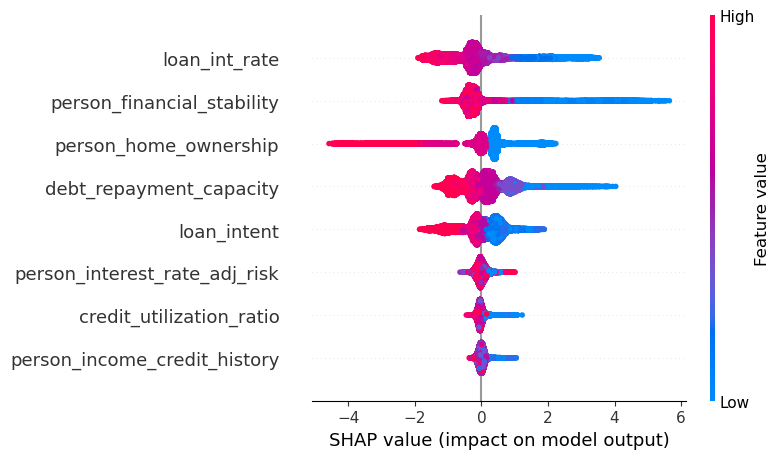

In [85]:
explainer = shap.Explainer(best_model, X)
shap_values = explainer(X)
shap.summary_plot(shap_values,X)

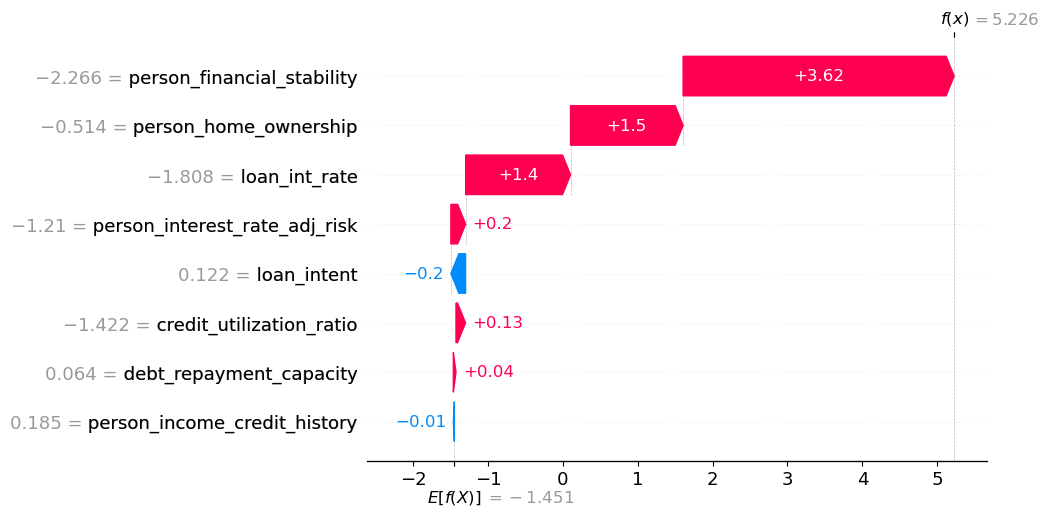

In [91]:
shap.plots.waterfall(shap_values[0])

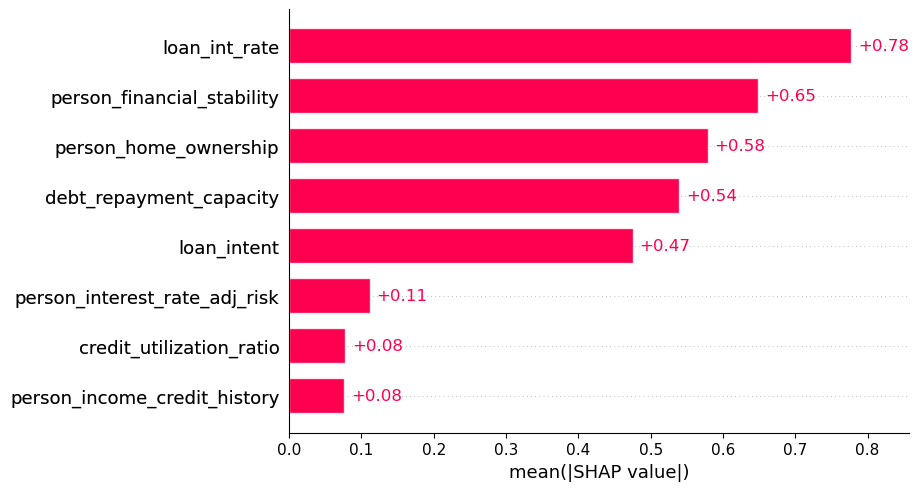

In [92]:
shap.plots.bar(shap_values)